# Example Notebook

In [1]:
# example.ipynb

from chemoecology_tools.core import GCMSExperiment
from chemoecology_tools.analysis import (
    calculate_enrichment_table,
    perform_nmds,
    perform_lda,
    perform_pca,
    perform_random_forest,
    calculate_compositional_stats,
)
from chemoecology_tools.visualization import (
    plot_nmds,
    plot_lda,
    plot_pca,
    plot_rf_importance,
)

In [2]:
USER_PROVIDED_CHEMICAL_METADATA_PATH = "../example_data/user_provided_chemical_metadata.yaml"
ABUNDANCE_DATA_PATH = "../example_data/lbal23_relative_abundance.csv"
USER_PROVIDED_SAMPLE_METADATA_PATH = "../example_data/lbal23_metadata.csv"
ID_COLUMN = "Bee #"
FILTER_DICT={
    "CHC File Located": ["NO", "Bleed"],
    "Quality": ["poor", "contaminated"],
    "Nest Code": ["E-JS-030", "E-JS-033", "E-JS-037", "E-KO-140", "E-KO-143"]
}

In [3]:
# Load experimental data with metadata
experiment = GCMSExperiment.from_files(
    abundance_path=ABUNDANCE_DATA_PATH,
    metadata_path=USER_PROVIDED_SAMPLE_METADATA_PATH,
    id_col=ID_COLUMN,
    filter_dict=FILTER_DICT,
    fetch_pubchem=True,
    user_chemical_metadata=USER_PROVIDED_CHEMICAL_METADATA_PATH,
)

In [4]:
print(experiment)

Unnamed experiment: 84 samples, 48 chemicals measured


In [5]:
# Filter and process data
filtered = experiment.filter_trace_compounds(threshold=0.005)
relative = filtered.calculate_relative_abundance()

In [6]:
filtered.metadata_df.head()

,Bee #,Nest Code,CHC File Located,All Nestmates?,Social Phenotype,Date,Reproductivity,Caste,Notes,Brood Notes,...,Ovariole Length,Oocyte Index,DF Width,DF Length (mm),Behavior Score,Behavior Score Subordinate Classifier,Behavioral Notes,Bead Assay,Dissection Type,CHC Notes
0,129,A-KO-053,yes,Yes,Solitary,6/26/23,Some_rep,Sol_rep,NaN,NaN,...,2.103,0.230623,0.531,3.237,No contact,NaN,pilot assay,Pentane,RNAlater ICE,NaN
1,135,A-KO-055,yes,Yes,Solitary,6/26/23,Some_rep,Sol_nr,NaN,"1 pupa collected, squished 2 pupa",...,3.148,0.307814,0.476,2.917,NaN,NaN,No assay,No assay,RNAlater ICE,NaN
2,137,F-KO-056,yes,Yes,Solitary,6/26/23,Some_rep,Sol_nr,NaN,Brood squished,...,2.279,0.237385,0.490,3.177,No contact,NaN,pilot assay,Pentane,RNAlater ICE,NaN
3,138,E-SW-001,yes,Yes,Solitary,6/26/23,Some_rep,Sol_rep,NaN,No brood,...,2.070,0.397101,0.479,3.480,NaN,NaN,No assay,No assay,RNAlater ICE,NaN
4,139,E-SW-002,yes,Yes,Solitary,6/26/23,No_rep,Sol_nr,NaN,No brood,...,2.133,0.157525,0.522,3.293,Pass,Neutral,"pilot assay, agitated with tapping and q tip",Mono alkenes,RNAlater ICE,NaN


In [7]:
import pandas as pd

meta_mask = filtered.metadata_df["Caste"].isin(["Sol_rep", "Sol_nr"])
chem_mask = pd.Series([
    filtered.get_chemical_property(c, "class") == "Alkane"
    for c in filtered.chemical_cols
], index=filtered.chemical_cols)

In [8]:
filtered_exp = experiment.filter(
    metadata_mask=meta_mask,
    chemical_mask=chem_mask
)
print(filtered_exp)

Unnamed experiment: 21 samples, 9 chemicals measured


In [9]:
nmds_df = perform_nmds(filtered_exp)
nmds_df.head()

,NMDS1,NMDS2
0,-0.310959,-1.266179
1,1.116833,0.421703
2,-0.384450,-2.398551
3,-3.503039,-1.569737
4,-1.580674,-3.585599


/Users/wolf/git/chemoecology-tools/src/chemoecology_tools/visualization/plotting.py:142: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(


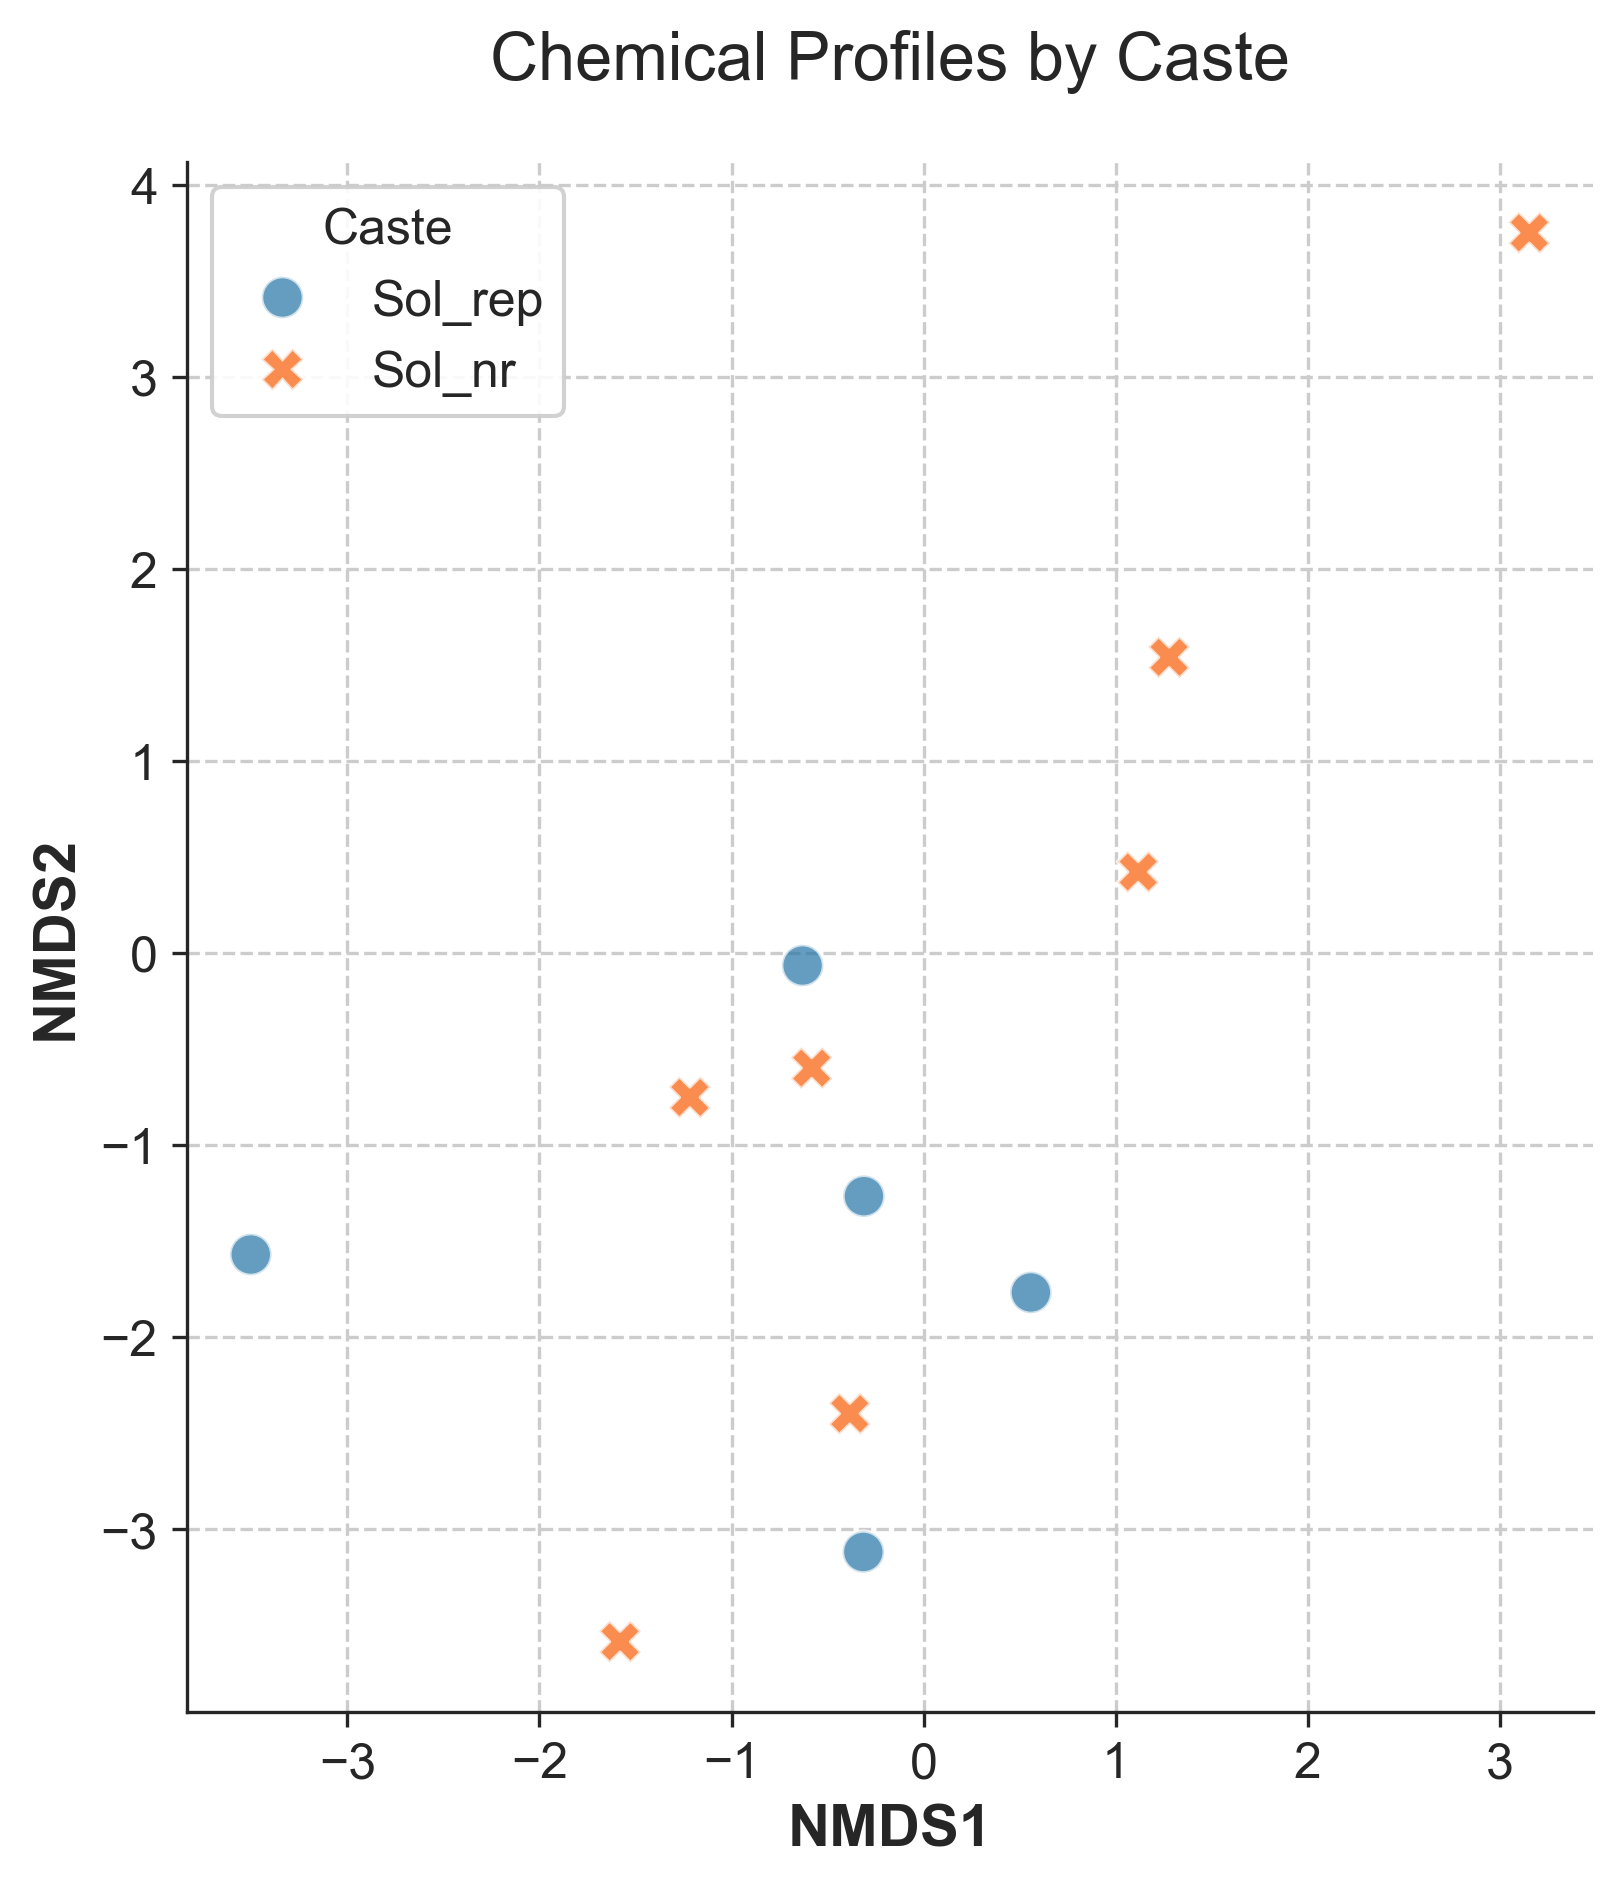

In [10]:
# Create plots with different groupings
# By caste
fig1 = plot_nmds(
    experiment=filtered_exp,
    nmds_coords=nmds_df,
    group_col="Caste",
    title="Chemical Profiles by Caste"
)

In [11]:
clr_output = calculate_compositional_stats(filtered_exp)

In [12]:
results = perform_pca(clr_output) 

PCA explained variance ratios: [4.56591623e-01 1.79306952e-01 1.29023075e-01 9.43402096e-02
 6.21066245e-02 4.00442709e-02 2.50507196e-02 1.00435832e-02
 3.49294173e-03 2.56169559e-31]


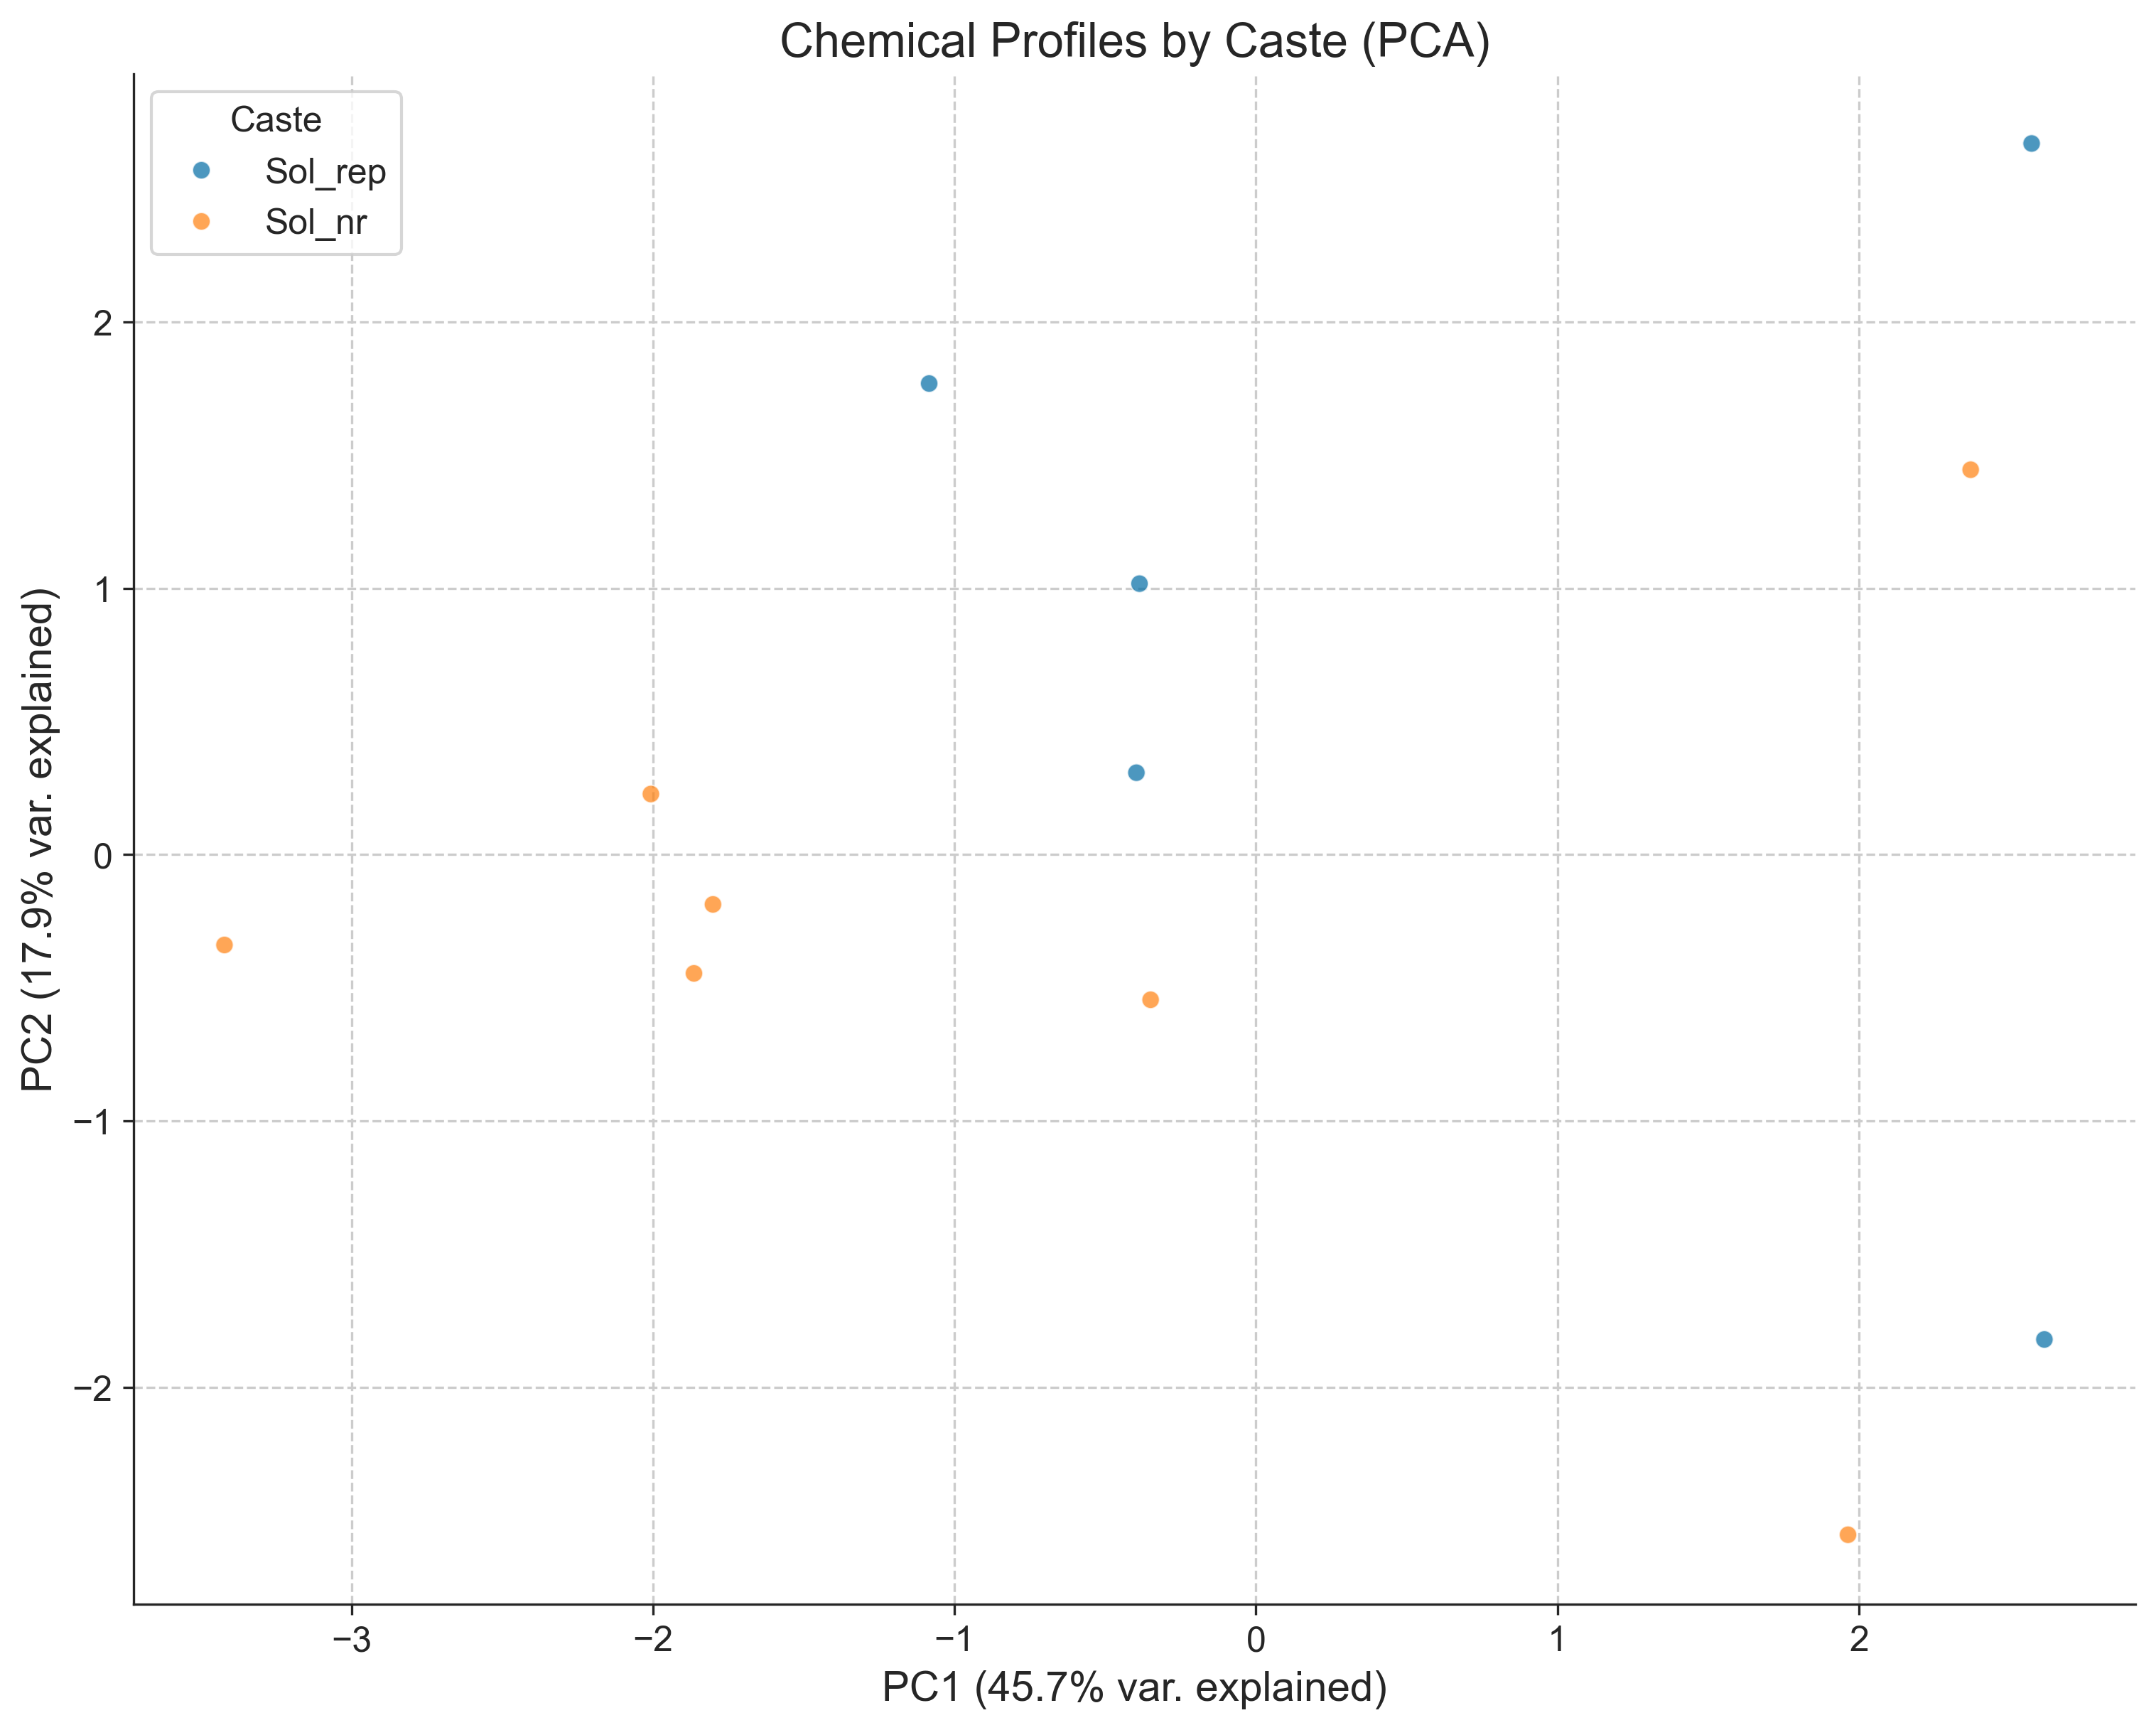

In [13]:

pca_coords = results["coords"]
explained_var = results["explained_variance"]

print(f"PCA explained variance ratios: {explained_var}")
# Create PCA plot
fig2 = plot_pca(
    pca_results=results,
    experiment=filtered_exp,
    group_col="Caste",
    title="Chemical Profiles by Caste (PCA)"
)

In [14]:
# Initialize results dictionary
results = {}

# Initialize group column and title prefix
group_col = "Caste"
title_prefix = "Chemical Profiles"

# 3. LDA Analysis
transformed_data = calculate_compositional_stats(filtered)
lda_results = perform_lda(
    transformed_data=transformed_data,
    experiment=filtered,
    group_col=group_col
)

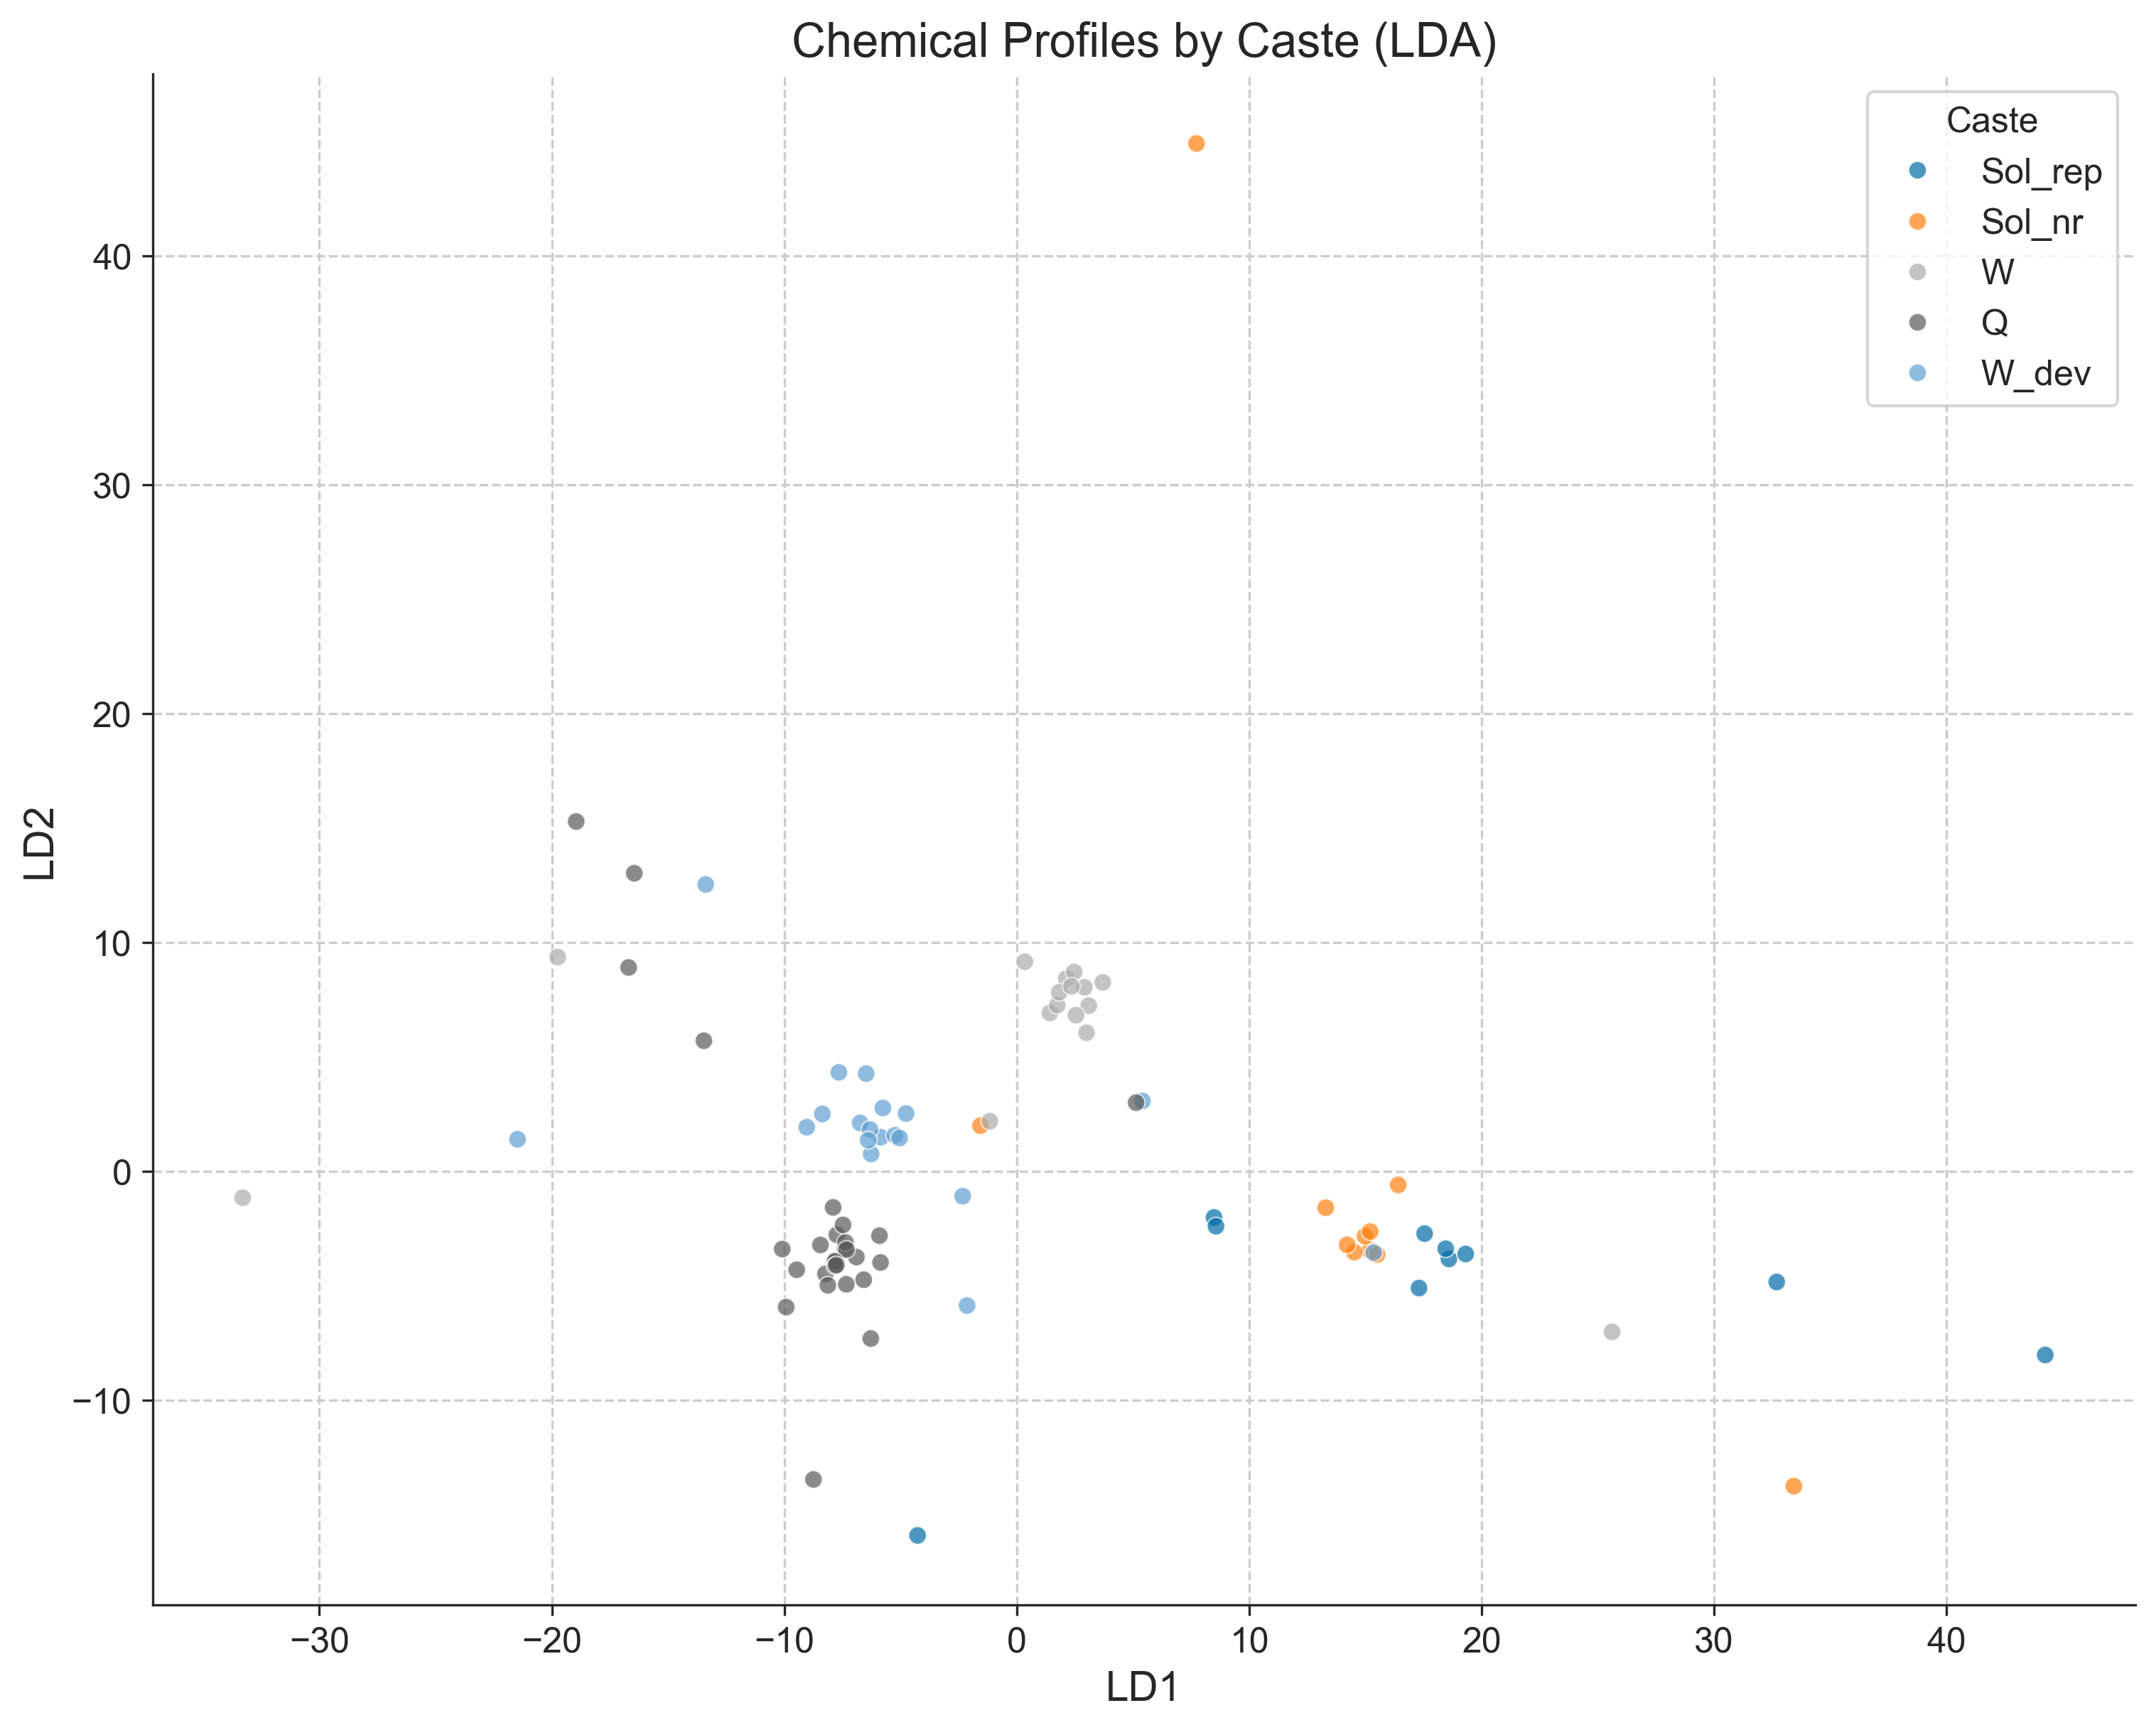

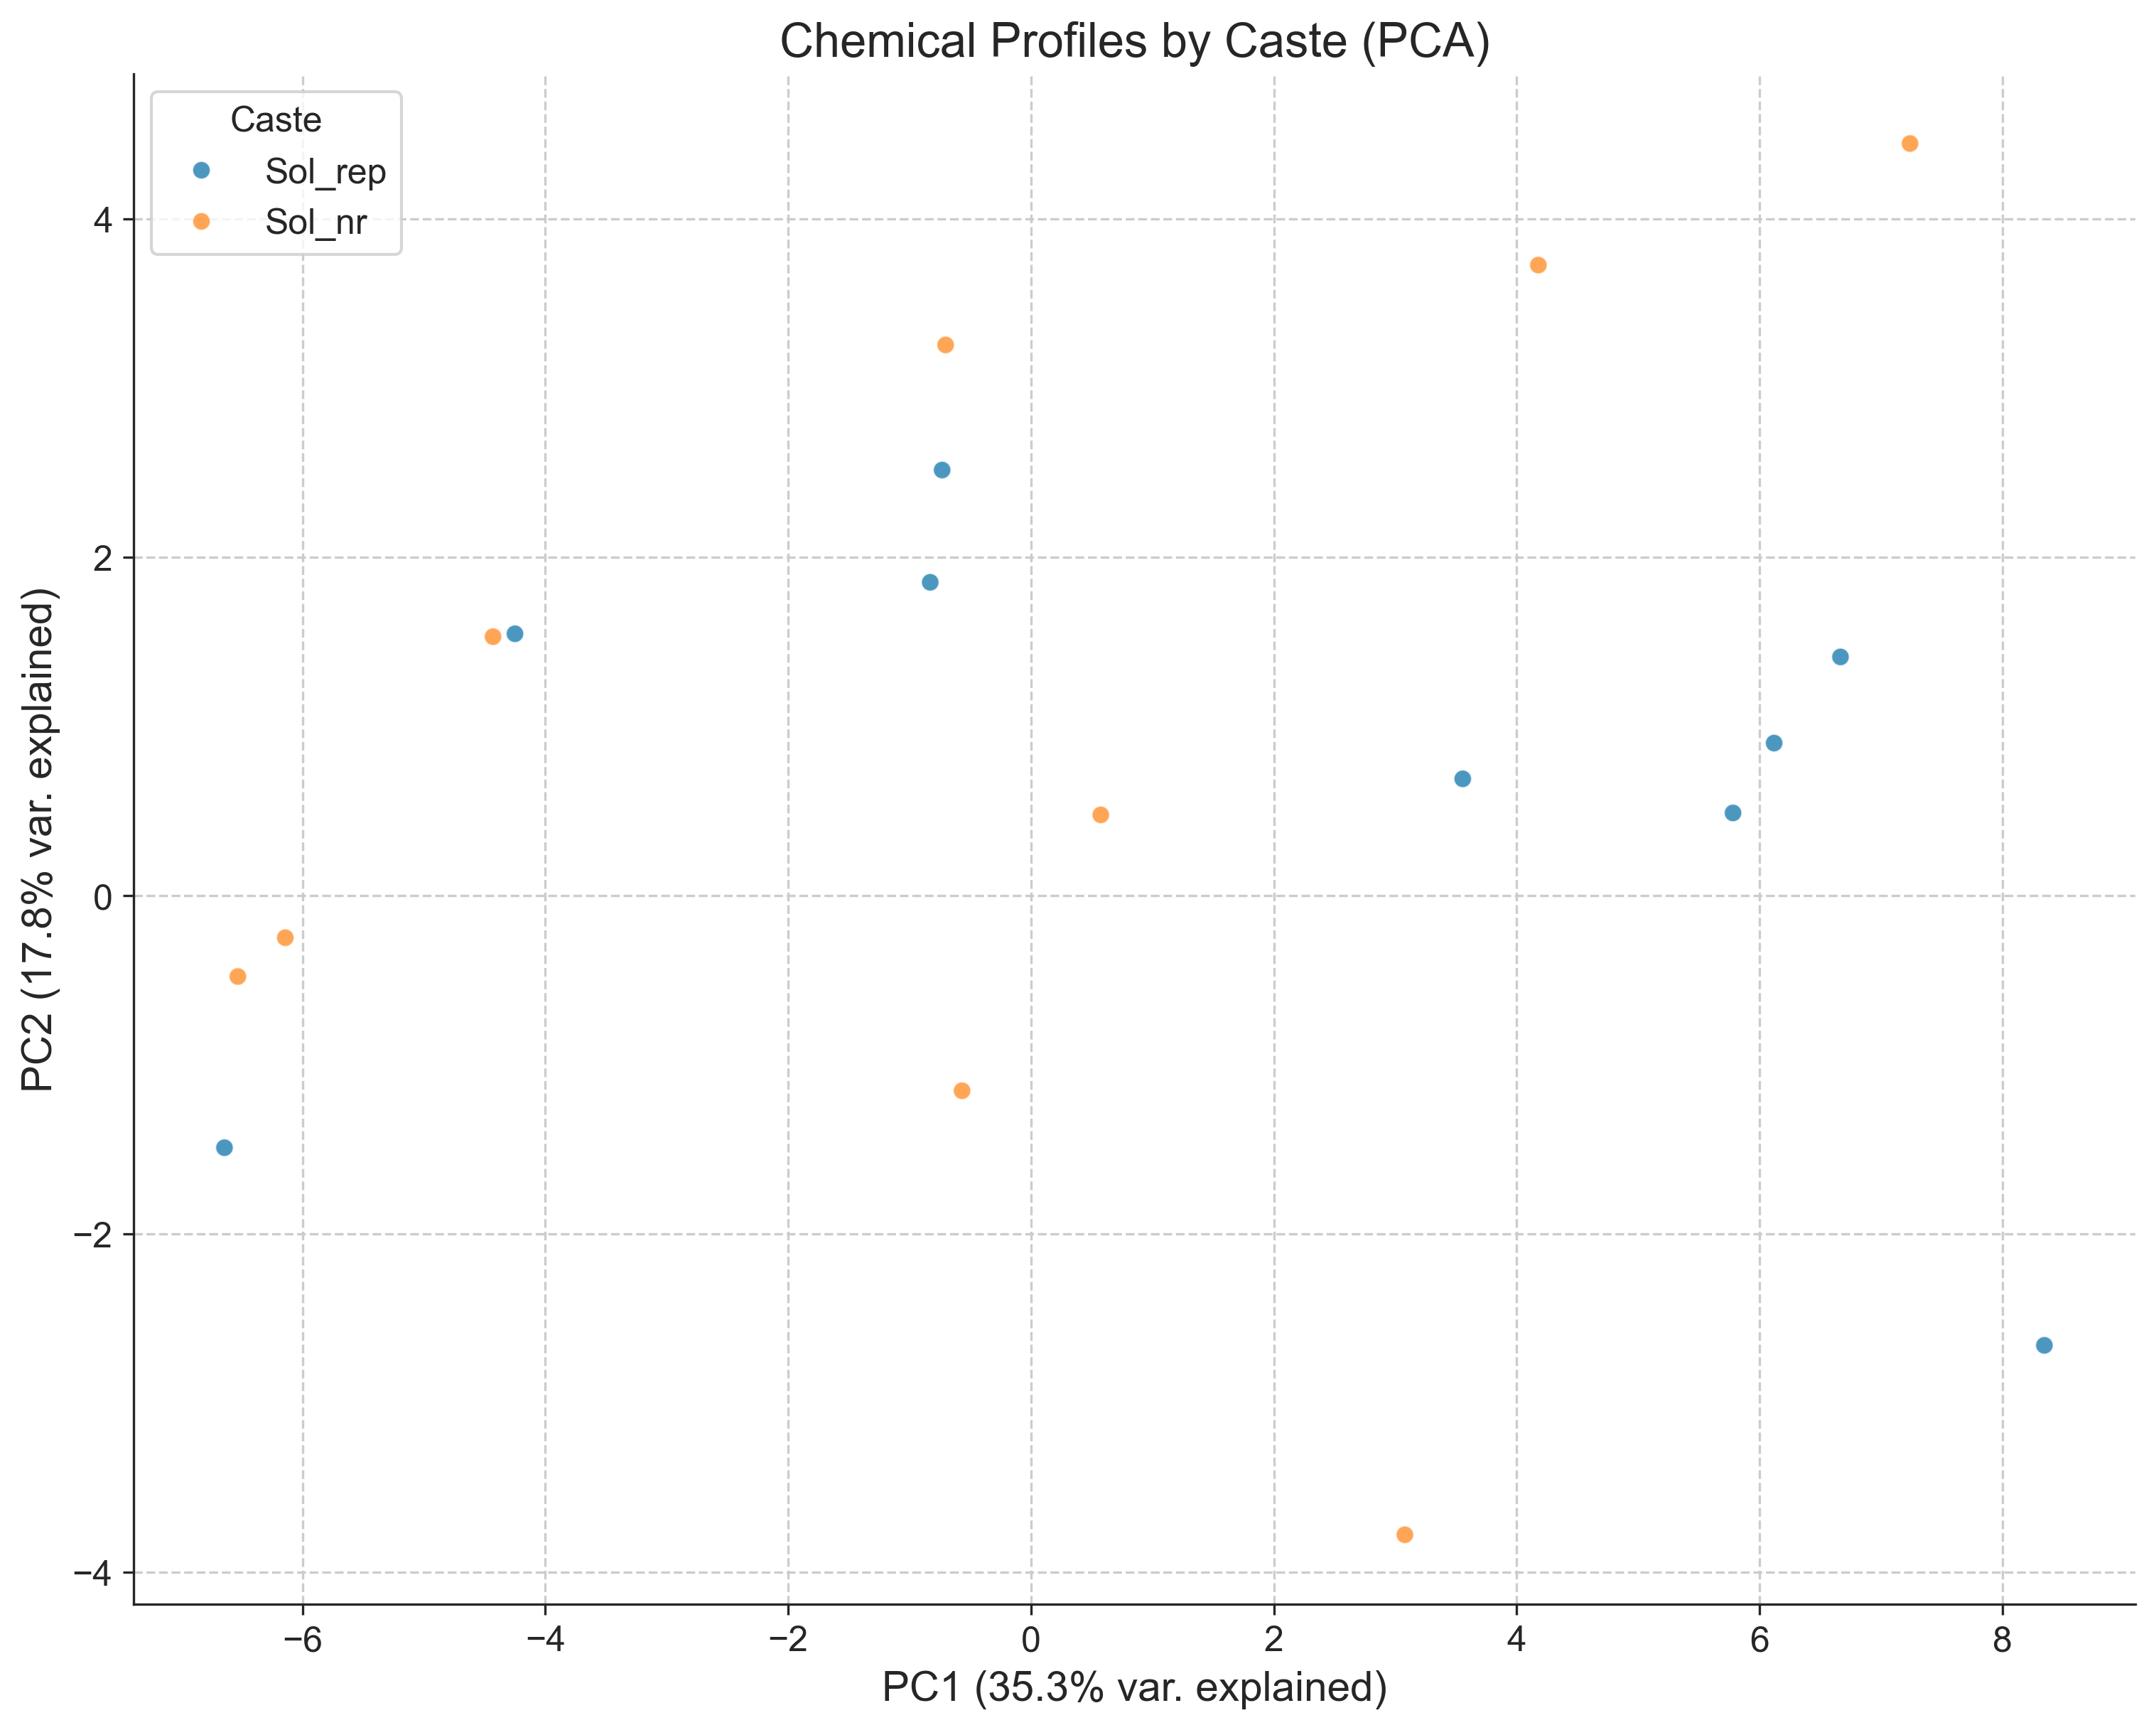

In [15]:
fig_lda = plot_lda(
    lda_results=lda_results,
    experiment=filtered,
    group_col=group_col,
    title=f"{title_prefix} by {group_col} (LDA)"
)

# 4. PCA Analysis (already CLR transformed)
pca_results = perform_pca(transformed_data)

fig_pca = plot_pca(
    pca_results=pca_results,
    experiment=filtered_exp,
    group_col=group_col,
    title=f"{title_prefix} by {group_col} (PCA)"
)


In [16]:
# Generate enrichment table
enrichment_table = calculate_enrichment_table(
    experiment=filtered,
    group_column='Caste',
    class_column='class',
    alpha=0.05
)

In [17]:
enrichment_table.head()

,Chemical Class,Compound,KW_pvalue,Group Bias,Sol_rep,Sol_nr,W,Q,W_dev
7,Aldehyde,Eicosanal,0.249934,,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
2,Aldehyde,Octadecanal,0.390423,,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00
3,Alkane,Heneicosane,0.000008,"Sol_nr, Sol_rep",1.87 ± 0.58,1.72 ± 0.61,0.05 ± 0.00,0.09 ± 0.02,0.08 ± 0.02
26,Alkane,Heptacosane,0.043065,W_dev,2.29 ± 0.35,2.15 ± 0.33,2.06 ± 0.18,2.84 ± 0.26,3.35 ± 0.33
33,Alkane,Nonacosane,0.001116,"Q, Sol_nr, Sol_rep, W_dev",0.24 ± 0.04,0.22 ± 0.04,0.08 ± 0.01,0.25 ± 0.09,0.22 ± 0.03


In [18]:
perform_random_forest(
    transformed_data=transformed_data,
    experiment=filtered,
    group_col="Caste",
    test_size=0.3
)

{'feature_importance':                               feature  importance
 18                           Docosene    0.061372
 19                     Unknown RI2568    0.048067
 24                     Heptacosadiene    0.045206
 32                         Nonacosene    0.043822
 7                      Octadecenolide    0.043744
 14                        Pentacosene    0.043048
 26                        Heptacosene    0.033542
 25                     Unknown RI2687    0.032189
 4                         Heneicosane    0.030467
 38  3-Methyl-3-Butenyl Tetracosanoate    0.029543
 35                     Hexacosenolide    0.027092
 17           11/13-methylpentacosane?    0.025216
 10                          Tricosane    0.024246
 40                   Pentatriacontene    0.022899
 37                        Triacontane    0.022509
 29                         Octacosane    0.021014
 16                     Unknown RI2496    0.020181
 9                           Tricosene    0.019832
 44      